# 2.1.2 Analytic expressions

In [1]:
%matplotlib nbagg

import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

class HuberSVM:       
    def __init__(self, num_samples, C=1, h=0.5):
        self.C = C
        self.n = num_samples
        self.h = h
        
    def _huber_loss(self, _X, _y, _w):
        yt = _y * np.dot(_X, _w)
        retval = np.where(yt > (1 + self.h), 0, np.where(yt < (1-self.h), 1 - yt, (1+self.h-yt)**2/(4*self.h)))
        return retval
    
    def _huber_gradient(self, _X, _y, _w):
        yt = _y * np.dot(_X, _w)
        minus_yx = -1*(_y*_X.T).T
        minus_h_to_h = (np.multiply(minus_yx.T,(1+self.h-yt)/(2*self.h))).T
        gradient_vector = np.zeros(_X.shape[1])
        for index, _yt in enumerate(yt):
            loss_at_index = np.zeros(_X.shape[1])
            
            if yt[index] < (1-self.h):
                loss_at_index = minus_yx[index]
            elif yt[index] > (1+self.h):
                loss_at_index = loss_at_index
            else:
                loss_at_index = minus_h_to_h[index]
            gradient_vector = gradient_vector + loss_at_index
                
        return gradient_vector
        
    def fit(self, X, y):
        self.data = X
        self.target = y
        
    def compute_obj(self,w):
        yt = np.dot(self.data,w)
        obj = np.power(LA.norm(w),2) + (self.C/self.n)*np.dot(self._huber_loss(self.data, self.target, w), np.ones(self.data.shape[0]))
        return obj;
    
    def compute_grad(self, w):
        return 2*w + (self.C/self.n)*self._huber_gradient(self.data,self.target,w)

# Numeric check

In [2]:
def grad_checker(objective_fn, w):
    epsilon = 10**-4
    calculated_gradient = []
    for directional_vector in np.eye(w.shape[0], w.shape[0]):
        gradient= (objective_fn(w+epsilon*directional_vector) - objective_fn(w-epsilon*directional_vector))/(2*epsilon)
        calculated_gradient.append(gradient)
    return calculated_gradient

# Testing with iris

10.9937327611
[ 0.52212557  6.0692376   2.00889798]
[0.52212557340780563, 6.0692375986270974, 2.0088979843535526]


<IPython.core.display.Javascript object>


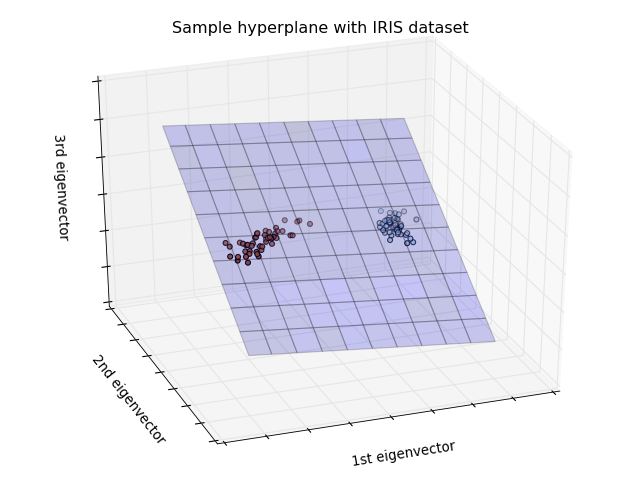

In [3]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

iris = load_iris()
X_iris = PCA(n_components=3).fit_transform(iris.data[:100])
Y_iris = iris.target[:100]


svm = HuberSVM(X_iris.shape[0])
svm.fit(X_iris, Y_iris)

#w = np.ones(X_reduced.shape[1])
w = np.array([0.5,3,1])
print(svm.compute_obj(w))
print(svm.compute_grad(w))
print(grad_checker(svm.compute_obj,w))

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

ax.scatter(X_iris[:, 0], X_iris[:, 1], X_iris[:, 2], c=Y_iris,
           cmap=plt.cm.Paired)
ax.set_title("Sample hyperplane with IRIS dataset")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

x_cord, y_cord = np.meshgrid(np.linspace(-3,3,100),np.linspace(-3,3,100))
z_cord = -1*(w[0]*x_cord+w[1]*y_cord)/w[2]
ax.plot_surface(x_cord, y_cord, z_cord, alpha=0.2)
plt.show()


# Generate gaussian samples

In [4]:
def generate_gaussian_samples(n_samples, m_dimension):
    C = np.random.uniform(low=-1,high=1,size=(m_dimension,m_dimension))
    #X = np.r_[np.dot(np.random.randn(int(n_samples/2), m_dimension), C), 
    #          np.dot(np.random.randn(int(n_samples/2), m_dimension), C) + np.ones(m_dimension)]
    
    #
    #Quick hack to make two well separated clusters
    #
    X = np.r_[np.dot(np.random.randn(int(n_samples/2), m_dimension), C), 
              np.dot(np.random.randn(int(n_samples/2), m_dimension), C) + np.array([2,3, 5])]
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    y = np.ones(n_samples)
    y[:int(n_samples/2)] = -1
    return X, y

# Gradient Descent
This is a generic gradient descent as we can pass any objective function and gradient function along with other parameters

In [5]:
def my_gradient_descent(X, y, obj_fn, grad_fn, eta=0.1, max_iterations = 1000):
    w = np.zeros(X.shape[1])
    objective_fn_values = []
    numeric_correctness = []
    misclassification_errors = []
    
    for iter in range(0, max_iterations):
        objective_fn_values.append(obj_fn(w))
        gradient = grad_fn(w)
        numeric_correctness.append(np.sum(gradient - grad_checker(obj_fn, w)))
        misclassification_errors.append((np.multiply(np.dot(X,w), y) < 0).sum())
        w = w - eta*gradient
    
    return w, numeric_correctness, objective_fn_values, misclassification_errors

In [6]:
X_train, y_train = generate_gaussian_samples(500,3)
X_test, y_test = generate_gaussian_samples(500,3)
svm = HuberSVM(X_train.shape[0])
svm.fit(X_train, y_train)
w_final, num_correct, obj_values, miss_errors = my_gradient_descent(X_train, y_train, svm.compute_obj, svm.compute_grad)

[ 0.20993311  0.33349709  0.33680183]


<IPython.core.display.Javascript object>


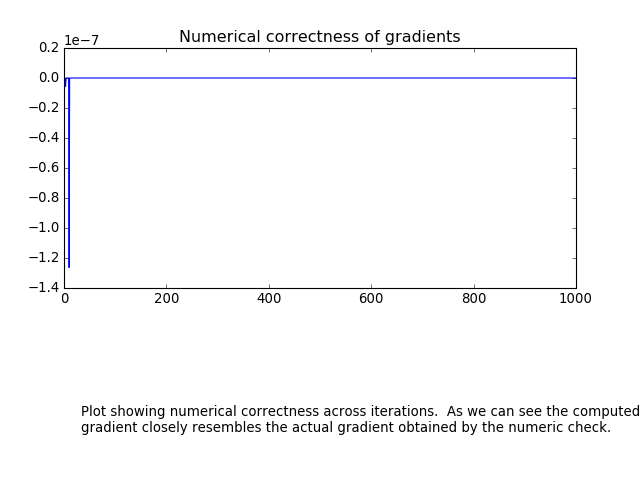

In [7]:
print(w_final)
plt.close()

fig = plt.figure()
ax1 = fig.add_axes((.1,.4,.8,.5))
ax1.plot(range(0, 1000), num_correct)
plt.title("Numerical correctness of gradients")
txt = '''
    Plot showing numerical correctness across iterations.  As we can see the computed
    gradient closely resembles the actual gradient obtained by the numeric check.'''

fig.text(.1,.1,txt)
plt.show()

<IPython.core.display.Javascript object>


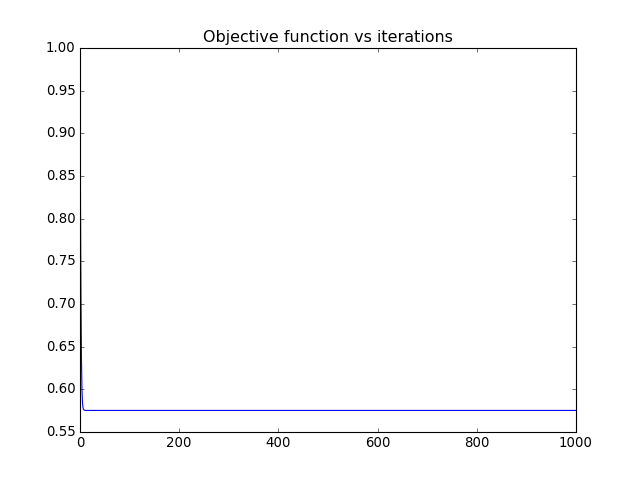

In [8]:
plt.close()
fig = plt.figure()
plt.title("Objective function vs iterations")

plt.plot(range(0, 1000), obj_values)
plt.show()

<IPython.core.display.Javascript object>


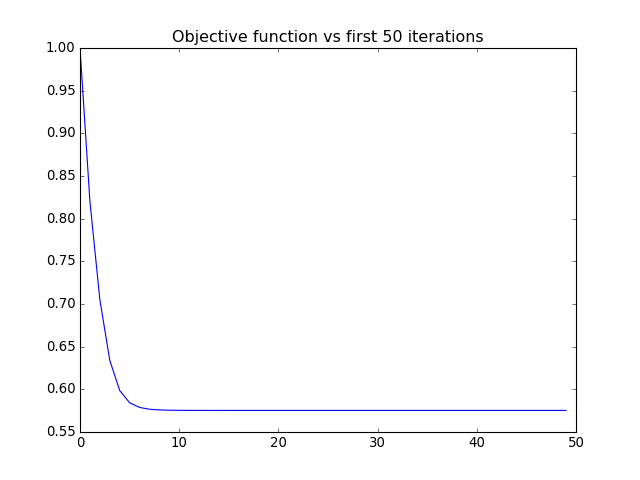

In [9]:
plt.close()
fig = plt.figure()
plt.title("Objective function vs first 50 iterations")

plt.plot(range(0, 50), obj_values[:50])
plt.show()

<IPython.core.display.Javascript object>


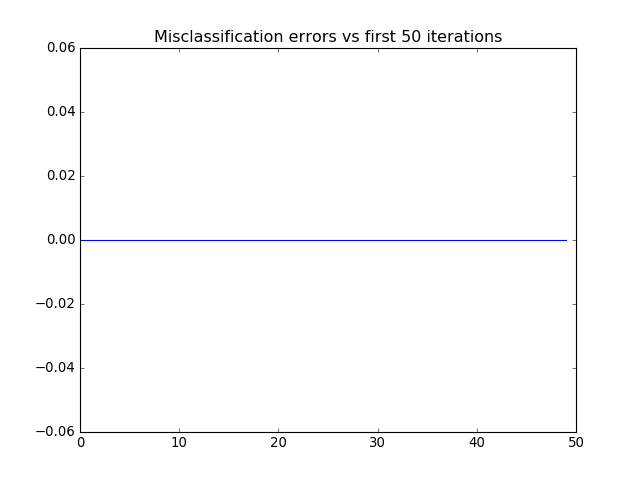

In [10]:
plt.close()
fig = plt.figure()
plt.title("Misclassification errors vs first 50 iterations")

plt.plot(range(0, 50), miss_errors[:50])
plt.show()

## Observation
Sometimes we can observe a spike in misclassification error in the beginning and then a constant decrease in the misclassificaiton error.  This is because as we move the hyper plane according to gradient descent, we tend to make a few errors before convergint at the optimum

<IPython.core.display.Javascript object>


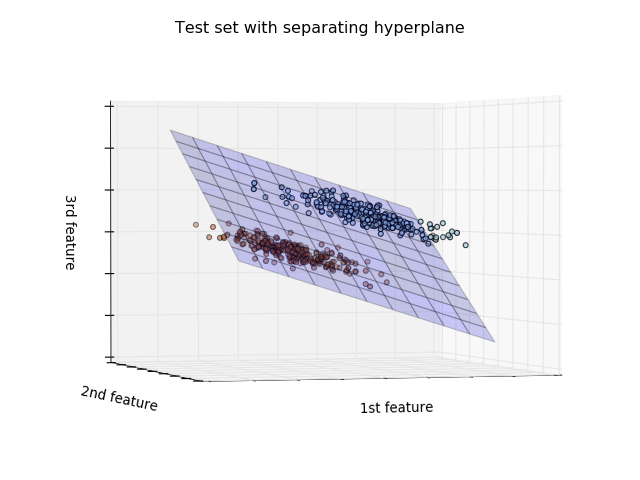

In [11]:
plt.close()

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train,cmap=plt.cm.Paired)
ax.set_title("Test set with separating hyperplane")
ax.set_xlabel("1st feature")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd feature")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd feature")
ax.w_zaxis.set_ticklabels([])

x_cord, y_cord = np.meshgrid(np.linspace(-3,3,100),np.linspace(-3,3,100))
z_cord = -1*(w_final[0]*x_cord+w_final[1]*y_cord)/w_final[2]
ax.plot_surface(x_cord, y_cord, z_cord, alpha=0.2)
plt.show()


# observation
As we can observe, this is not a maximum margin hyperplane.